# 2o Miniprojeto - LSTM

*   Eulália Aires
*   Douglas Cavalcante

## Montando a LSTM

Montando a estrutura da LSTM e carregando os dados

In [ ]:
#Instalando dependências

!pip install tensorflow #for prediction
!pip install numpy  #for matrix multiplication
!pip install pandas #define the data structures
!pip install matplotlib #for visualization
!pip install scikit-learn #for normalizing our data(scaling)

#Importando bibliotecas
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import io
from itertools import cycle
%matplotlib inline


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
#Carregando o dataset
from google.colab import files
uploaded = files.upload()

Saving btc.csv to btc.csv


In [ ]:
#Lendo e analisando os dados do dataset
btc = pd.read_csv(io.StringIO(uploaded['btc.csv'].decode('utf-8')))

# Ordenando dataset por data
btc['Date'] = pd.to_datetime(btc['Date'])
btc.sort_values(by='Date', ascending=True, inplace=True)
btc.head()

,Date,Symbol,Open,High,Low,Close,Volume From,Volume To
1272,2014-12-01,BTCUSD,300.0,370.0,300.00,370.0,0.05656,19.53
1271,2014-12-02,BTCUSD,370.0,378.0,370.00,378.0,15.01000,5675.07
1270,2014-12-03,BTCUSD,378.0,378.0,377.01,378.0,0.54660,206.52
1269,2014-12-04,BTCUSD,378.0,378.0,377.10,377.1,0.01000,3.77
1268,2014-12-05,BTCUSD,377.1,377.1,377.10,377.1,0.00000,0.00


In [ ]:
#Selecionando a variável alvo
data_to_use=btc['Close'].values
data_to_use

array([ 370.  ,  378.  ,  378.  , ..., 7584.15, 7459.11, 7520.  ])

In [ ]:
#Pré-processando os dados(scaling)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_to_use.reshape(-1, 1))

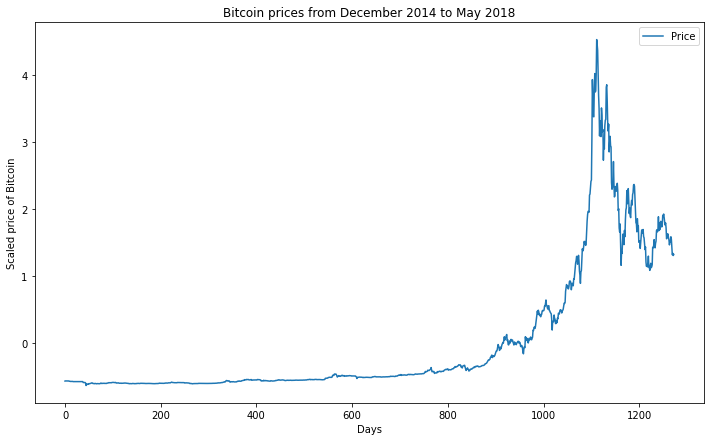

In [ ]:
#Plotando gráfico dos dados
import matplotlib.pyplot as plt
plt.figure(figsize=(12,7), frameon=False, facecolor='brown', edgecolor='blue')
plt.title('Bitcoin prices from December 2014 to May 2018')
plt.xlabel('Days')
plt.ylabel('Scaled price of Bitcoin')
plt.plot(scaled_data, label='Price')
plt.legend()
plt.show()

## Modelo 1

Usando período de 7 dias entre as previsões

*   batch size = 7
*   window size = 7
*   camada oculta = 256 neurônios
*   learning rate = 0.001
*   epochs = 200

In [ ]:
# This function is used to create Features and Labels datasets. By windowing the data.
#Input: data - dataset used in the project
#window_size - how many data points we are going to use to predict the next datapoint in the sequence 
#[Example: if window_size = 1 we are going to use only the previous day to predict todays stock prices]
#Outputs: X - features splitted into windows of datapoints (if window_size = 1, X = [len(data)-1, 1])
#y - 'labels', actually this is the next number in the sequence, this number we are trying to predict

def window_data(data, window_size):
    X = []
    y = []
    
    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
        
        i += 1
    assert len(X) ==  len(y)
    return X, y

#windowing the data with window_data function
X, y = window_data(scaled_data, 7)


#Dividindo o conjunto em dados de treinamento e dados de teste (80% para treinamento e 20% para teste)

X_train  = np.array(X[:1018])
y_train = np.array(y[:1018])

X_test = np.array(X[1018:])
y_test = np.array(y[1018:])

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (1018, 7, 1)
y_train size: (1018, 1)
X_test size: (248, 7, 1)
y_test size: (248, 1)


In [ ]:
# Definindo hiperparâmetros da rede
batch_size = 7 #how many windows of data we are passing at once
window_size = 7 #how big window_size is (Or How many days do we consider to predict next point in the sequence)
hidden_layer = 256 #How many units do we use in LSTM cell
clip_margin = 4 #To prevent exploding gradient, we use clipper to clip gradients below -margin or above this margin
learning_rate = 0.001 
epochs = 200 

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# Definindo os placeholders
inputs = tf.placeholder(tf.float32, [batch_size, window_size, 1])
targets = tf.placeholder(tf.float32, [batch_size, 1])

In [ ]:
# Definindo os pesos da LSTM 


# Pesos input gate
weights_input_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_input_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_input = tf.Variable(tf.zeros([hidden_layer]))

# Pesos forget gate
weights_forget_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_forget_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_forget = tf.Variable(tf.zeros([hidden_layer]))

# Pesos output gate
weights_output_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_output_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_output = tf.Variable(tf.zeros([hidden_layer]))

# Pesos memória
weights_memory_cell = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_memory_cell_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_memory_cell = tf.Variable(tf.zeros([hidden_layer]))

# Pesos output layer
weights_output = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
bias_output_layer = tf.Variable(tf.zeros([1]))

# Calculando gate states
def LSTM_cell(input, output, state):
    
    input_gate = tf.sigmoid(tf.matmul(input, weights_input_gate) + tf.matmul(output, weights_input_hidden) + bias_input)
    
    forget_gate = tf.sigmoid(tf.matmul(input, weights_forget_gate) + tf.matmul(output, weights_forget_hidden) + bias_forget)
    
    output_gate = tf.sigmoid(tf.matmul(input, weights_output_gate) + tf.matmul(output, weights_output_hidden) + bias_output)
    
    memory_cell = tf.tanh(tf.matmul(input, weights_memory_cell) + tf.matmul(output, weights_memory_cell_hidden) + bias_memory_cell)
    
    state = state * forget_gate + input_gate * memory_cell
    
    output = output_gate * tf.tanh(state)
    return state, output
  
  
 # Definindo loop da rede
outputs = []
for i in range(batch_size): #Iterates through every window in the batch
  
    
    batch_state = np.zeros([1, hidden_layer], dtype=np.float32) 
    batch_output = np.zeros([1, hidden_layer], dtype=np.float32)
    
    #for each point in the window we are feeding that into LSTM to get next output
    for ii in range(window_size):
        batch_state, batch_output = LSTM_cell(tf.reshape(inputs[i][ii], (-1, 1)), batch_state, batch_output)
        
    #last output is conisdered and used to get a prediction
    outputs.append(tf.matmul(batch_output, weights_output) + bias_output_layer)
outputs 

[<tf.Tensor 'add_63:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_127:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_191:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_255:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_319:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_383:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_447:0' shape=(1, 1) dtype=float32>]

In [ ]:
#Definindo a perda
losses = []

for i in range(len(outputs)):
    losses.append(tf.losses.mean_squared_error(tf.reshape(targets[i], (-1, 1)), outputs[i]))
    
loss = tf.reduce_mean(losses)

# Definindo otimizador usando gradient clipping
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, clip_margin)
optimizer = tf.train.AdamOptimizer(learning_rate)
trained_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))

#Treinando a rede
session = tf.Session()
session.run(tf.global_variables_initializer())
for i in range(epochs):
    traind_scores = []
    ii = 0
    epoch_loss = []
    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]
        
        o, c, _ = session.run([outputs, loss, trained_optimizer], feed_dict={inputs:X_batch, targets:y_batch})
        
        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
    if (i % 30) == 0:
      print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))

Epoch 0/200  Current loss: 0.020382888615131378
Epoch 30/200  Current loss: 0.04185006394982338
Epoch 60/200  Current loss: 0.005436684936285019
Epoch 90/200  Current loss: 0.004839625209569931
Epoch 120/200  Current loss: 0.003746546572074294
Epoch 150/200  Current loss: 0.0035396073944866657
Epoch 180/200  Current loss: 0.001968622673302889


In [ ]:
model1_trained =[]
for i in range(len(traind_scores)):
    for j in range(len(traind_scores[i])):
        model1_trained.append(traind_scores[i][j][0])

In [ ]:
model1_tests = []
i = 0
while i+batch_size <= len(X_test): 
  
    o = session.run([outputs],feed_dict={inputs:X_test[i:i+batch_size]})
    i += batch_size
    model1_tests.append(o)

In [ ]:
model1_tests_new = []
for i in range(len(model1_tests)):
  for j in range(len(model1_tests[i][0])):
    model1_tests_new.append(model1_tests[i][0][j])

In [ ]:
model1_test_results = []
for i in range(1264): # periodo de teste no caso de maio 2014 a dezembro 2018
      if i >= 1019:
        model1_test_results.append(model1_tests_new[i-1019])
      else:
        model1_test_results.append(None)

### Predições

/usr/local/lib/python3.9/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


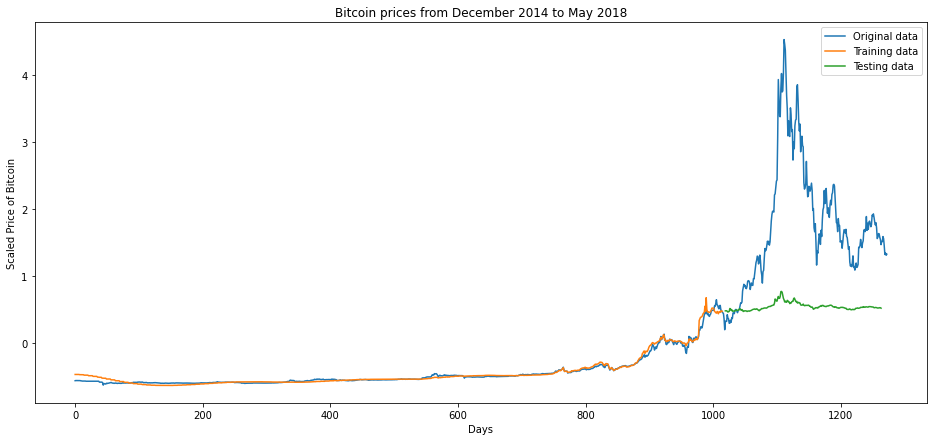

In [ ]:
plt.figure(figsize=(16, 7))
plt.title('Bitcoin prices from December 2014 to May 2018')
plt.xlabel('Days')
plt.ylabel('Scaled Price of Bitcoin')
plt.plot(scaled_data, label='Original data')
plt.plot(model1_trained, label='Training data')
plt.plot(model1_test_results, label='Testing data')
plt.legend()
plt.show()


## Modelo 2
Usando período de 3 dias entre as previsões

*   batch size = 7
*   window size = 3
*   camada oculta = 256 neurônios
*   learning rate = 0.001
*   epochs = 200


In [ ]:
# This function is used to create Features and Labels datasets. By windowing the data.
#Input: data - dataset used in the project
#window_size - how many data points we are going to use to predict the next datapoint in the sequence 
#[Example: if window_size = 1 we are going to use only the previous day to predict todays stock prices]
#Outputs: X - features splitted into windows of datapoints (if window_size = 1, X = [len(data)-1, 1])
#y - 'labels', actually this is the next number in the sequence, this number we are trying to predict

def window_data(data, window_size):
    X = []
    y = []
    
    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
        
        i += 1
    assert len(X) ==  len(y)
    return X, y

#windowing the data with window_data function
X, y = window_data(scaled_data, 3)


#Dividindo o conjunto em dados de treinamento e dados de teste (80% para treinamento e 20% para teste)

X_train  = np.array(X[:1018])
y_train = np.array(y[:1018])

X_test = np.array(X[1018:])
y_test = np.array(y[1018:])

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (1018, 3, 1)
y_train size: (1018, 1)
X_test size: (252, 3, 1)
y_test size: (252, 1)


In [ ]:
# Definindo hiperparâmetros da rede
batch_size = 7 #how many windows of data we are passing at once
window_size = 3 #how big window_size is (Or How many days do we consider to predict next point in the sequence)
hidden_layer = 256 #How many units do we use in LSTM cell
clip_margin = 4 #To prevent exploding gradient, we use clipper to clip gradients below -margin or above this margin
learning_rate = 0.001 
epochs = 200 

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# Definindo os placeholders
inputs = tf.placeholder(tf.float32, [batch_size, window_size, 1])
targets = tf.placeholder(tf.float32, [batch_size, 1])

In [ ]:
# Definindo os pesos da LSTM 


# Pesos input gate
weights_input_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_input_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_input = tf.Variable(tf.zeros([hidden_layer]))

# Pesos forget gate
weights_forget_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_forget_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_forget = tf.Variable(tf.zeros([hidden_layer]))

# Pesos output gate
weights_output_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_output_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_output = tf.Variable(tf.zeros([hidden_layer]))

# Pesos memória
weights_memory_cell = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_memory_cell_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_memory_cell = tf.Variable(tf.zeros([hidden_layer]))

# Pesos output layer
weights_output = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
bias_output_layer = tf.Variable(tf.zeros([1]))

# Calculando gate states
def LSTM_cell(input, output, state):
    
    input_gate = tf.sigmoid(tf.matmul(input, weights_input_gate) + tf.matmul(output, weights_input_hidden) + bias_input)
    
    forget_gate = tf.sigmoid(tf.matmul(input, weights_forget_gate) + tf.matmul(output, weights_forget_hidden) + bias_forget)
    
    output_gate = tf.sigmoid(tf.matmul(input, weights_output_gate) + tf.matmul(output, weights_output_hidden) + bias_output)
    
    memory_cell = tf.tanh(tf.matmul(input, weights_memory_cell) + tf.matmul(output, weights_memory_cell_hidden) + bias_memory_cell)
    
    state = state * forget_gate + input_gate * memory_cell
    
    output = output_gate * tf.tanh(state)
    return state, output
  
  
 # Definindo loop da rede
outputs = []
for i in range(batch_size): #Iterates through every window in the batch
  
    
    batch_state = np.zeros([1, hidden_layer], dtype=np.float32) 
    batch_output = np.zeros([1, hidden_layer], dtype=np.float32)
    
    #for each point in the window we are feeding that into LSTM to get next output
    for ii in range(window_size):
        batch_state, batch_output = LSTM_cell(tf.reshape(inputs[i][ii], (-1, 1)), batch_state, batch_output)
        
    #last output is conisdered and used to get a prediction
    outputs.append(tf.matmul(batch_output, weights_output) + bias_output_layer)
outputs 

[<tf.Tensor 'add_475:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_503:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_531:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_559:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_587:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_615:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_643:0' shape=(1, 1) dtype=float32>]

In [ ]:
#Definindo a perda
losses = []

for i in range(len(outputs)):
    losses.append(tf.losses.mean_squared_error(tf.reshape(targets[i], (-1, 1)), outputs[i]))
    
loss = tf.reduce_mean(losses)

# Definindo otimizador usando gradient clipping
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, clip_margin)
optimizer = tf.train.AdamOptimizer(learning_rate)
trained_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))

#Treinando a rede
session = tf.Session()
session.run(tf.global_variables_initializer())
for i in range(epochs):
    traind_scores = []
    ii = 0
    epoch_loss = []
    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]
        
        o, c, _ = session.run([outputs, loss, trained_optimizer], feed_dict={inputs:X_batch, targets:y_batch})
        
        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
    if (i % 30) == 0:
      print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))

Epoch 0/200  Current loss: 0.02486802637577057
Epoch 30/200  Current loss: 0.003545468905940652
Epoch 60/200  Current loss: 0.0017884118715301156
Epoch 90/200  Current loss: 0.0011944373836740851
Epoch 120/200  Current loss: 0.001806627493351698
Epoch 150/200  Current loss: 0.0008766026585362852
Epoch 180/200  Current loss: 0.0012736517237499356


In [ ]:
model2_trained =[]
for i in range(len(traind_scores)):
    for j in range(len(traind_scores[i])):
        model2_trained.append(traind_scores[i][j][0])

In [ ]:
model2_tests = []
i = 0
while i+batch_size <= len(X_test): 
  
    o = session.run([outputs],feed_dict={inputs:X_test[i:i+batch_size]})
    i += batch_size
    model2_tests.append(o)

In [ ]:
model2_tests_new = []
for i in range(len(model2_tests)):
  for j in range(len(model2_tests[i][0])):
    model2_tests_new.append(model2_tests[i][0][j])

In [ ]:
model2_test_results = []
for i in range(1264): # periodo de teste no caso de maio 2014 a dezembro 2018
      if i >= 1019:
        model2_test_results.append(model2_tests_new[i-1019])
      else:
        model2_test_results.append(None)

### Predições

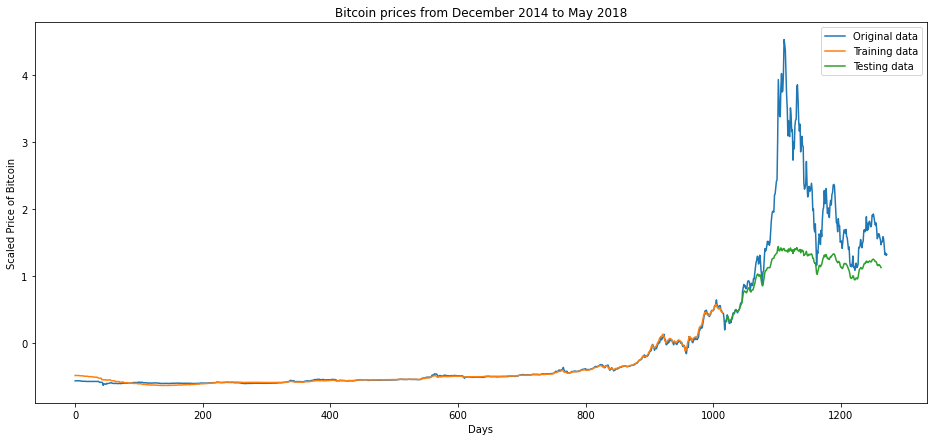

In [ ]:
plt.figure(figsize=(16, 7))
plt.title('Bitcoin prices from December 2014 to May 2018')
plt.xlabel('Days')
plt.ylabel('Scaled Price of Bitcoin')
plt.plot(scaled_data, label='Original data')
plt.plot(model2_trained, label='Training data')
plt.plot(model2_test_results, label='Testing data')
plt.legend()
plt.show()

## Modelo 1 x 2

O modelo 2 com `window size = 3` tem predição mais próxima que o modelo 1 `window size = 7`, isso pode ser visto no gráfico pela linha laranja mais próxima a azul. Essa questão se justifica por uma menor janela de dias causar uma retroalimentação melhor do looping da rede neural.

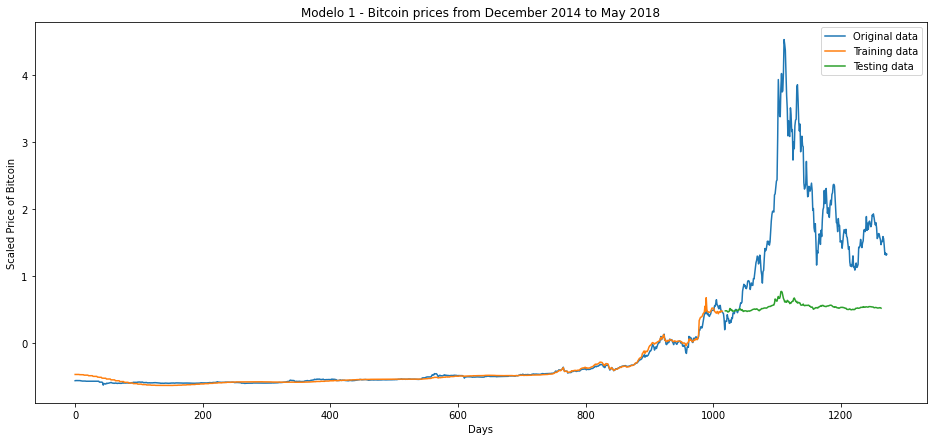

In [ ]:
# Modelo 1

plt.figure(figsize=(16, 7))
plt.title('Modelo 1 - Bitcoin prices from December 2014 to May 2018')
plt.xlabel('Days')
plt.ylabel('Scaled Price of Bitcoin')
plt.plot(scaled_data, label='Original data')
plt.plot(model1_trained, label='Training data')
plt.plot(model1_test_results, label='Testing data')
plt.legend()
plt.show()

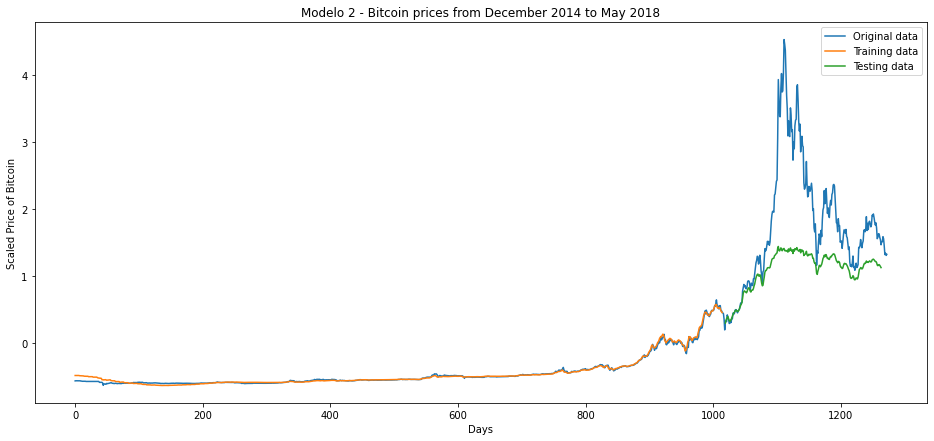

In [ ]:
# Modelo 2

plt.figure(figsize=(16, 7))
plt.title('Modelo 2 - Bitcoin prices from December 2014 to May 2018')
plt.xlabel('Days')
plt.ylabel('Scaled Price of Bitcoin')
plt.plot(scaled_data, label='Original data')
plt.plot(model2_trained, label='Training data')
plt.plot(model2_test_results, label='Testing data')
plt.legend()
plt.show()

## Modelo 3
Aumentando a quantidade de neurônios na camada interna

*   batch size = 7
*   window size = 3
*   camada oculta = 200 neurônios
*   learning rate = 0.001
*   epochs = 200

In [ ]:
# This function is used to create Features and Labels datasets. By windowing the data.
#Input: data - dataset used in the project
#window_size - how many data points we are going to use to predict the next datapoint in the sequence 
#[Example: if window_size = 1 we are going to use only the previous day to predict todays stock prices]
#Outputs: X - features splitted into windows of datapoints (if window_size = 1, X = [len(data)-1, 1])
#y - 'labels', actually this is the next number in the sequence, this number we are trying to predict

def window_data(data, window_size):
    X = []
    y = []
    
    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
        
        i += 1
    assert len(X) ==  len(y)
    return X, y

#windowing the data with window_data function
X, y = window_data(scaled_data, 7)


#Dividindo o conjunto em dados de treinamento e dados de teste (80% para treinamento e 20% para teste)

X_train  = np.array(X[:1018])
y_train = np.array(y[:1018])

X_test = np.array(X[1018:])
y_test = np.array(y[1018:])

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (1018, 7, 1)
y_train size: (1018, 1)
X_test size: (248, 7, 1)
y_test size: (248, 1)


In [ ]:
# Definindo hiperparâmetros da rede
batch_size = 7 #how many windows of data we are passing at once
window_size = 7 #how big window_size is (Or How many days do we consider to predict next point in the sequence)
hidden_layer = 200 #How many units do we use in LSTM cell
clip_margin = 4 #To prevent exploding gradient, we use clipper to clip gradients below -margin or above this margin
learning_rate = 0.001 
epochs = 200 

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# Definindo os placeholders
inputs = tf.placeholder(tf.float32, [batch_size, window_size, 1])
targets = tf.placeholder(tf.float32, [batch_size, 1])

In [ ]:
# Definindo os pesos da LSTM 


# Pesos input gate
weights_input_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_input_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_input = tf.Variable(tf.zeros([hidden_layer]))

# Pesos forget gate
weights_forget_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_forget_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_forget = tf.Variable(tf.zeros([hidden_layer]))

# Pesos output gate
weights_output_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_output_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_output = tf.Variable(tf.zeros([hidden_layer]))

# Pesos memória
weights_memory_cell = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_memory_cell_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_memory_cell = tf.Variable(tf.zeros([hidden_layer]))

# Pesos output layer
weights_output = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
bias_output_layer = tf.Variable(tf.zeros([1]))

# Calculando gate states
def LSTM_cell(input, output, state):
    
    input_gate = tf.sigmoid(tf.matmul(input, weights_input_gate) + tf.matmul(output, weights_input_hidden) + bias_input)
    
    forget_gate = tf.sigmoid(tf.matmul(input, weights_forget_gate) + tf.matmul(output, weights_forget_hidden) + bias_forget)
    
    output_gate = tf.sigmoid(tf.matmul(input, weights_output_gate) + tf.matmul(output, weights_output_hidden) + bias_output)
    
    memory_cell = tf.tanh(tf.matmul(input, weights_memory_cell) + tf.matmul(output, weights_memory_cell_hidden) + bias_memory_cell)
    
    state = state * forget_gate + input_gate * memory_cell
    
    output = output_gate * tf.tanh(state)
    return state, output
  
  
 # Definindo loop da rede
outputs = []
for i in range(batch_size): #Iterates through every window in the batch
  
    
    batch_state = np.zeros([1, hidden_layer], dtype=np.float32) 
    batch_output = np.zeros([1, hidden_layer], dtype=np.float32)
    
    #for each point in the window we are feeding that into LSTM to get next output
    for ii in range(window_size):
        batch_state, batch_output = LSTM_cell(tf.reshape(inputs[i][ii], (-1, 1)), batch_state, batch_output)
        
    #last output is conisdered and used to get a prediction
    outputs.append(tf.matmul(batch_output, weights_output) + bias_output_layer)
outputs 

[<tf.Tensor 'add_707:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_771:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_835:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_899:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_963:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_1027:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_1091:0' shape=(1, 1) dtype=float32>]

In [ ]:
#Definindo a perda
losses = []

for i in range(len(outputs)):
    losses.append(tf.losses.mean_squared_error(tf.reshape(targets[i], (-1, 1)), outputs[i]))
    
loss = tf.reduce_mean(losses)

# Definindo otimizador usando gradient clipping
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, clip_margin)
optimizer = tf.train.AdamOptimizer(learning_rate)
trained_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))

#Treinando a rede
session = tf.Session()
session.run(tf.global_variables_initializer())
for i in range(epochs):
    traind_scores = []
    ii = 0
    epoch_loss = []
    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]
        
        o, c, _ = session.run([outputs, loss, trained_optimizer], feed_dict={inputs:X_batch, targets:y_batch})
        
        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
    if (i % 30) == 0:
      print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))

Epoch 0/200  Current loss: 0.02369592897593975
Epoch 30/200  Current loss: 0.005185432266443968
Epoch 60/200  Current loss: 0.001607131096534431
Epoch 90/200  Current loss: 0.002381190424785018
Epoch 120/200  Current loss: 0.0016565878177061677
Epoch 150/200  Current loss: 0.0015838503604754806
Epoch 180/200  Current loss: 0.001182287815026939


In [ ]:
model3_trained =[]
for i in range(len(traind_scores)):
    for j in range(len(traind_scores[i])):
        model3_trained.append(traind_scores[i][j][0])

In [ ]:
model3_tests = []
i = 0
while i+batch_size <= len(X_test): 
  
    o = session.run([outputs],feed_dict={inputs:X_test[i:i+batch_size]})
    i += batch_size
    model3_tests.append(o)

In [ ]:
model3_tests_new = []
for i in range(len(model3_tests)):
  for j in range(len(model3_tests[i][0])):
    model3_tests_new.append(model3_tests[i][0][j])

In [ ]:
model3_test_results = []
for i in range(1264): # periodo de teste no caso de maio 2014 a dezembro 2018
      if i >= 1019:
        model3_test_results.append(model3_tests_new[i-1019])
      else:
        model3_test_results.append(None)

### Predições

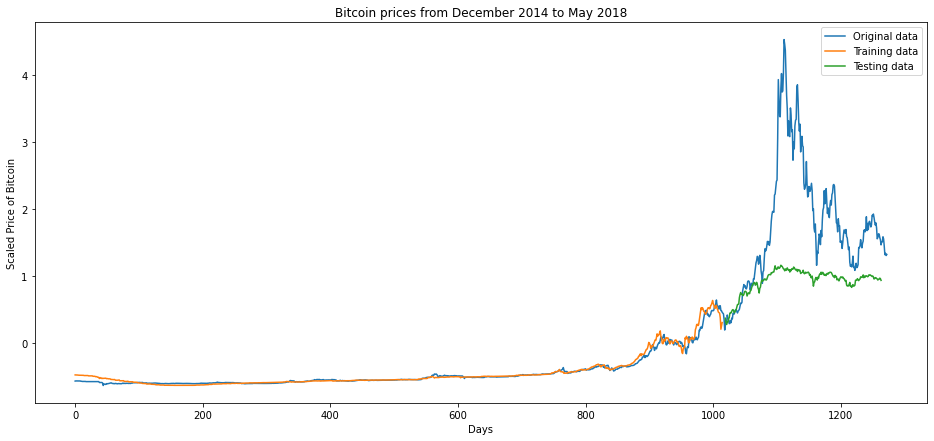

In [ ]:
plt.figure(figsize=(16, 7))
plt.title('Bitcoin prices from December 2014 to May 2018')
plt.xlabel('Days')
plt.ylabel('Scaled Price of Bitcoin')
plt.plot(scaled_data, label='Original data')
plt.plot(model3_trained, label='Training data')
plt.plot(model3_test_results, label='Testing data')
plt.legend()
plt.show()

## Modelo 2 x 3

O aumento da quantidade de neurônios na camada interna demonstra um desvio superior nos dados. 


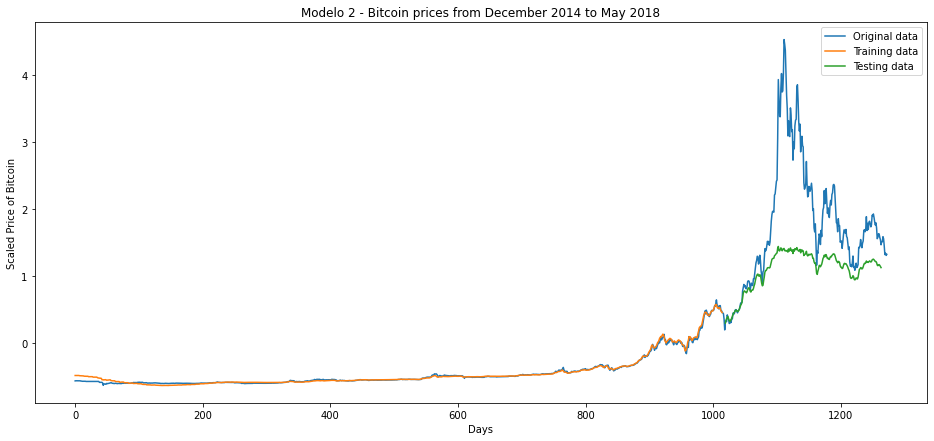

In [ ]:
# Modelo 2

plt.figure(figsize=(16, 7))
plt.title('Modelo 2 - Bitcoin prices from December 2014 to May 2018')
plt.xlabel('Days')
plt.ylabel('Scaled Price of Bitcoin')
plt.plot(scaled_data, label='Original data')
plt.plot(model2_trained, label='Training data')
plt.plot(model2_test_results, label='Testing data')
plt.legend()
plt.show()

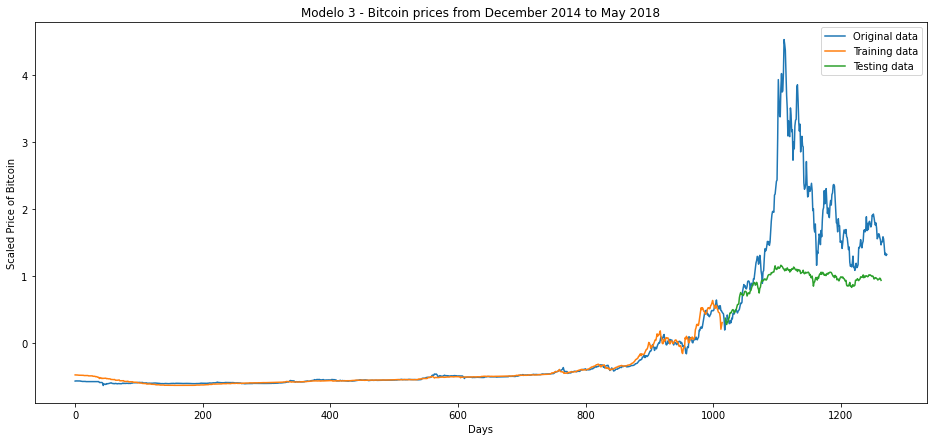

In [ ]:
# Modelo 3

plt.figure(figsize=(16, 7))
plt.title('Modelo 3 - Bitcoin prices from December 2014 to May 2018')
plt.xlabel('Days')
plt.ylabel('Scaled Price of Bitcoin')
plt.plot(scaled_data, label='Original data')
plt.plot(model3_trained, label='Training data')
plt.plot(model3_test_results, label='Testing data')
plt.legend()
plt.show()

## Modelo 4

Alterando a taxa de aprendizagem para 0.01

*   batch size = 7
*   window size = 3
*   camada oculta = 256 neurônios
*   learning rate = 0.01
*   epochs = 200

In [ ]:
# This function is used to create Features and Labels datasets. By windowing the data.
#Input: data - dataset used in the project
#window_size - how many data points we are going to use to predict the next datapoint in the sequence 
#[Example: if window_size = 1 we are going to use only the previous day to predict todays stock prices]
#Outputs: X - features splitted into windows of datapoints (if window_size = 1, X = [len(data)-1, 1])
#y - 'labels', actually this is the next number in the sequence, this number we are trying to predict

def window_data(data, window_size):
    X = []
    y = []
    
    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
        
        i += 1
    assert len(X) ==  len(y)
    return X, y

#windowing the data with window_data function
X, y = window_data(scaled_data, 3)


#Dividindo o conjunto em dados de treinamento e dados de teste (80% para treinamento e 20% para teste)

X_train  = np.array(X[:1018])
y_train = np.array(y[:1018])

X_test = np.array(X[1018:])
y_test = np.array(y[1018:])

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (1018, 3, 1)
y_train size: (1018, 1)
X_test size: (252, 3, 1)
y_test size: (252, 1)


In [ ]:
# Definindo hiperparâmetros da rede
batch_size = 7 #how many windows of data we are passing at once
window_size = 3 #how big window_size is (Or How many days do we consider to predict next point in the sequence)
hidden_layer = 256 #How many units do we use in LSTM cell
clip_margin = 4 #To prevent exploding gradient, we use clipper to clip gradients below -margin or above this margin
learning_rate = 0.01 
epochs = 200 

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# Definindo os placeholders
inputs = tf.placeholder(tf.float32, [batch_size, window_size, 1])
targets = tf.placeholder(tf.float32, [batch_size, 1])

In [ ]:
# Definindo os pesos da LSTM 


# Pesos input gate
weights_input_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_input_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_input = tf.Variable(tf.zeros([hidden_layer]))

# Pesos forget gate
weights_forget_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_forget_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_forget = tf.Variable(tf.zeros([hidden_layer]))

# Pesos output gate
weights_output_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_output_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_output = tf.Variable(tf.zeros([hidden_layer]))

# Pesos memória
weights_memory_cell = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_memory_cell_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_memory_cell = tf.Variable(tf.zeros([hidden_layer]))

# Pesos output layer
weights_output = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
bias_output_layer = tf.Variable(tf.zeros([1]))

# Calculando gate states
def LSTM_cell(input, output, state):
    
    input_gate = tf.sigmoid(tf.matmul(input, weights_input_gate) + tf.matmul(output, weights_input_hidden) + bias_input)
    
    forget_gate = tf.sigmoid(tf.matmul(input, weights_forget_gate) + tf.matmul(output, weights_forget_hidden) + bias_forget)
    
    output_gate = tf.sigmoid(tf.matmul(input, weights_output_gate) + tf.matmul(output, weights_output_hidden) + bias_output)
    
    memory_cell = tf.tanh(tf.matmul(input, weights_memory_cell) + tf.matmul(output, weights_memory_cell_hidden) + bias_memory_cell)
    
    state = state * forget_gate + input_gate * memory_cell
    
    output = output_gate * tf.tanh(state)
    return state, output
  
  
 # Definindo loop da rede
outputs = []
for i in range(batch_size): #Iterates through every window in the batch
  
    
    batch_state = np.zeros([1, hidden_layer], dtype=np.float32) 
    batch_output = np.zeros([1, hidden_layer], dtype=np.float32)
    
    #for each point in the window we are feeding that into LSTM to get next output
    for ii in range(window_size):
        batch_state, batch_output = LSTM_cell(tf.reshape(inputs[i][ii], (-1, 1)), batch_state, batch_output)
        
    #last output is conisdered and used to get a prediction
    outputs.append(tf.matmul(batch_output, weights_output) + bias_output_layer)
outputs 

[<tf.Tensor 'add_1315:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_1343:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_1371:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_1399:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_1427:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_1455:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_1483:0' shape=(1, 1) dtype=float32>]

In [ ]:
#Definindo a perda
losses = []

for i in range(len(outputs)):
    losses.append(tf.losses.mean_squared_error(tf.reshape(targets[i], (-1, 1)), outputs[i]))
    
loss = tf.reduce_mean(losses)

# Definindo otimizador usando gradient clipping
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, clip_margin)
optimizer = tf.train.AdamOptimizer(learning_rate)
trained_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))

#Treinando a rede
session = tf.Session()
session.run(tf.global_variables_initializer())
for i in range(epochs):
    traind_scores = []
    ii = 0
    epoch_loss = []
    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]
        
        o, c, _ = session.run([outputs, loss, trained_optimizer], feed_dict={inputs:X_batch, targets:y_batch})
        
        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
    if (i % 30) == 0:
      print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))

Epoch 0/200  Current loss: 0.010023325681686401
Epoch 30/200  Current loss: 0.015543516725301743
Epoch 60/200  Current loss: 0.014745342545211315
Epoch 90/200  Current loss: 0.001830986700952053
Epoch 120/200  Current loss: 0.003854926209896803
Epoch 150/200  Current loss: 0.0021828014869242907
Epoch 180/200  Current loss: 0.004529244266450405


In [ ]:
model4_trained =[]
for i in range(len(traind_scores)):
    for j in range(len(traind_scores[i])):
        model4_trained.append(traind_scores[i][j][0])

In [ ]:
model4_tests = []
i = 0
while i+batch_size <= len(X_test): 
  
    o = session.run([outputs],feed_dict={inputs:X_test[i:i+batch_size]})
    i += batch_size
    model4_tests.append(o)

In [ ]:
model4_tests_new = []
for i in range(len(model4_tests)):
  for j in range(len(model4_tests[i][0])):
    model4_tests_new.append(model4_tests[i][0][j])

In [ ]:
model4_test_results = []
for i in range(1264): # periodo de teste no caso de maio 2014 a dezembro 2018
      if i >= 1019:
        model4_test_results.append(model4_tests_new[i-1019])
      else:
        model4_test_results.append(None)

### Predições

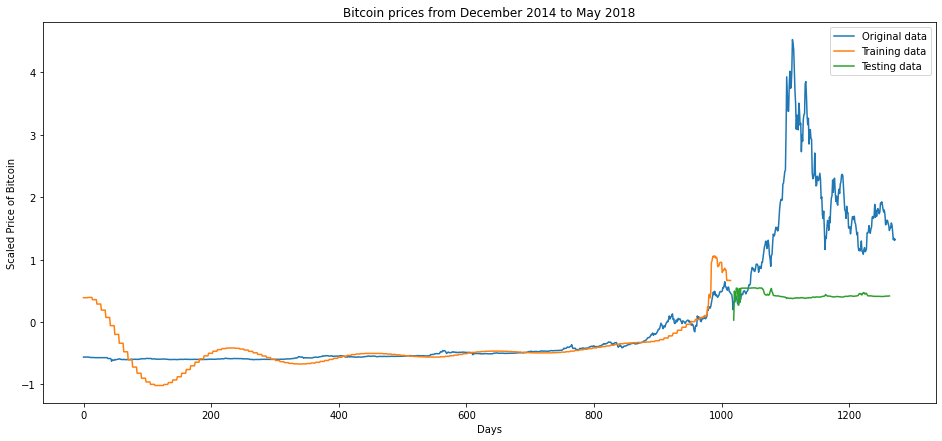

In [ ]:
plt.figure(figsize=(16, 7))
plt.title('Bitcoin prices from December 2014 to May 2018')
plt.xlabel('Days')
plt.ylabel('Scaled Price of Bitcoin')
plt.plot(scaled_data, label='Original data')
plt.plot(model4_trained, label='Training data')
plt.plot(model4_test_results, label='Testing data')
plt.legend()
plt.show()

## Modelo 2 x 4

A taxa de aprendizagem `0.01` deixa o modelo bastante instável, não sendo ideal para esse tipo de rede.

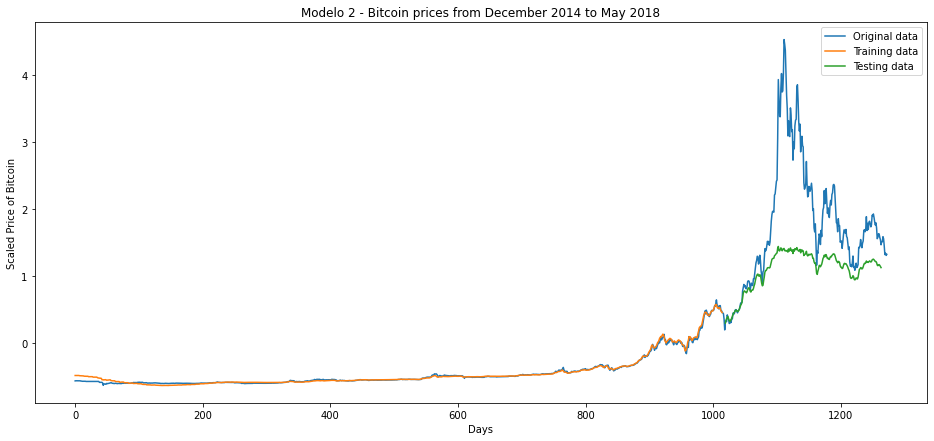

In [ ]:
# Modelo 2

plt.figure(figsize=(16, 7))
plt.title('Modelo 2 - Bitcoin prices from December 2014 to May 2018')
plt.xlabel('Days')
plt.ylabel('Scaled Price of Bitcoin')
plt.plot(scaled_data, label='Original data')
plt.plot(model2_trained, label='Training data')
plt.plot(model2_test_results, label='Testing data')
plt.legend()
plt.show()

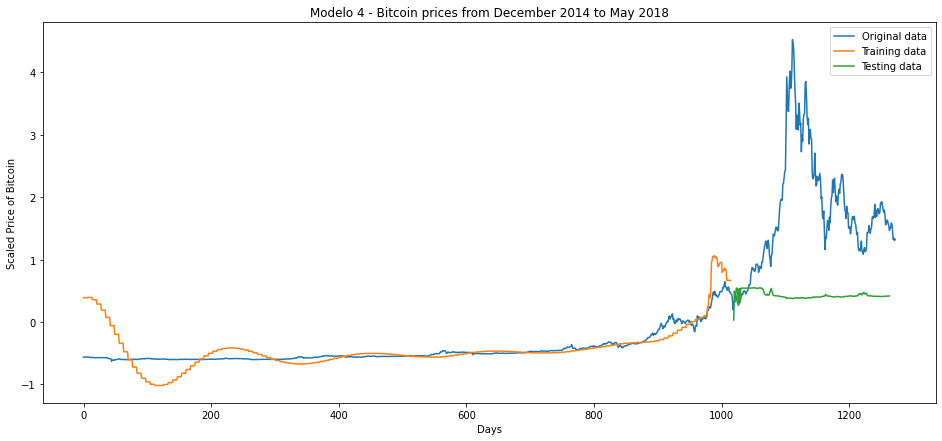

In [ ]:
# Modelo 4

plt.figure(figsize=(16, 7))
plt.title('Modelo 4 - Bitcoin prices from December 2014 to May 2018')
plt.xlabel('Days')
plt.ylabel('Scaled Price of Bitcoin')
plt.plot(scaled_data, label='Original data')
plt.plot(model4_trained, label='Training data')
plt.plot(model4_test_results, label='Testing data')
plt.legend()
plt.show()